### Libraries

In [1]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import pytest
import simpy
import xarray as xr

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock_new as lock_module
from opentnsim import energy as energy_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module
from opentnsim import zeesluisformulering as ZSF
from netCDF4 import Dataset
import datetime
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import folium
from shapely.ops import nearest_points, linemerge, split, snap, transform
import pyproj
import re
path = os.getcwd()
#filename = os.path.basename(__file__)
filename = os.path.basename(globals()['__session__'])

### Simulation

In [2]:
env = simpy.Environment()
t_start = datetime.datetime(2025, 1, 1, 0, 0, 0)
t_stop = datetime.datetime(2025, 1, 2, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())
env.epoch = t_start
env.simulation_start = t_start
env.simulation_stop = t_stop

### Network

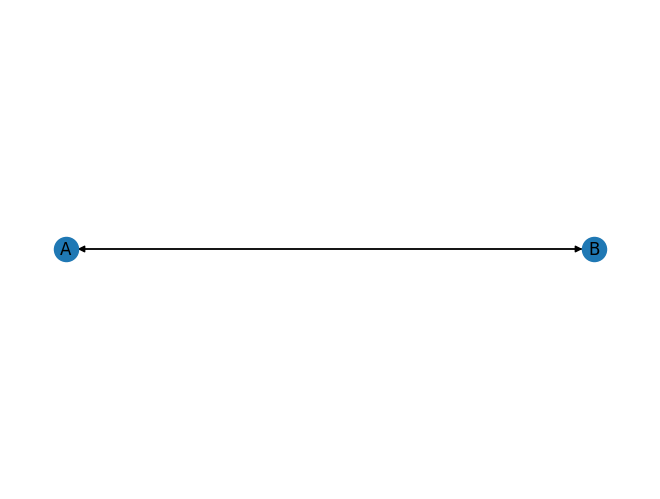

In [3]:
wgs84eqd = pyproj.CRS('4087')
wgs84rad = pyproj.CRS('4326')
wgs84eqd_to_wgs84rad = pyproj.transformer.Transformer.from_crs(wgs84eqd,wgs84rad,always_xy=True).transform
wgs84rad_to_wgs84eqd = pyproj.transformer.Transformer.from_crs(wgs84rad,wgs84eqd,always_xy=True).transform

graph = nx.MultiDiGraph()
graph.add_node('A',geometry=transform(wgs84eqd_to_wgs84rad,Point(-5000,0)))
graph.add_node('B',geometry=transform(wgs84eqd_to_wgs84rad,Point(5000,0)))
graph.add_edge('A','B',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(-5000,0),Point(5000,0)])),length=10000)
graph.add_edge('B','A',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(5000,0),Point(-5000,0)])),length=10000)
pos = {edge:(point.x,point.y) for edge,point in nx.get_node_attributes(graph, 'geometry').items()}
nx.draw(graph,pos,with_labels=True)
env.FG = graph

### Hydrodynamics

In [4]:
if not os.path.isdir(path+"\\hydrodynamic_data\\"):
    os.mkdir(path+"\\hydrodynamic_data\\")
if f"hydrodynamic_data_test_{filename}.nc" not in os.listdir(path+"\\hydrodynamic_data\\"):
    hydrodynamic_data = xr.Dataset()
    times = np.arange(t_start,t_stop,pd.Timedelta(5,'min'))
    nodes = np.array(['A','B'])
    wlevs = np.array([np.array([np.sin((2*np.pi/(12.5*60*60))*x) for x in np.arange(0,24*60*60,5*60)]),np.zeros(len(times))])
    salinity = np.array([30*np.ones(len(times)),np.zeros(len(times))])
    wlev_data = xr.DataArray(data=wlevs,coords={'STATION':nodes,'TIME':times})
    salinity_data = xr.DataArray(data=salinity,coords={'STATION':nodes,'TIME':times})
    hydrodynamic_data['Water level'] = wlev_data
    hydrodynamic_data['Salinity'] = salinity_data
    hydrodynamic_data.to_netcdf(path+f"\\hydrodynamic_data\\hydrodynamic_data_test_{filename}.nc")

### Vessel speed

In [5]:
if not os.path.isdir(path+"\\speed_data\\"):
    os.mkdir(path+"\\speed_data\\")
if "speed_data_test.pkl" not in os.listdir(path+"\\speed_data\\"):
    edge_index = [('A','B',0),('B','A',0)]
    data = np.array([6,6])
    vessel_speed_data = pd.DataFrame(data=data,columns=['Speed'],index=edge_index)
    vessel_speed_data.to_pickle(path + '\\speed_data\\speed_data_test.pkl')

### Vessel traffic services

In [6]:
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(FG=graph, 
                                                                                hydrodynamic_start_time = pd.Timestamp('2025-01-01 00:00'),
                                                                                hydrodynamic_information_path = path+f"\\hydrodynamic_data\\hydrodynamic_data_test_{filename}.nc", 
                                                                                vessel_speed_data_path = path + '\\speed_data\\speed_data_test.pkl')

### Lock object

In [9]:
lock = lock_module.IsLockComplex(env=env,
                                 name='Lock',
                                 start_node='A',
                                 node_open='A',
                                 end_node='B',
                                 node_A = 'A',
                                 node_B = 'B',
                                 distance_lock_doors_A_to_waiting_area_A = 4800,
                                 distance_lock_doors_B_to_waiting_area_B = 4800,
                                 distance_from_start_node_to_lock_doors_A = 4800,
                                 distance_from_end_node_to_lock_doors_B = 4800,
                                 lock_length = 400,
                                 lock_width = 30,
                                 lock_depth = 15,
                                 levelling_time = 300,
                                 clustering_time = 0.5*60*60,
                                 #P_used_to_break_before_lock=1.0,
                                 #P_used_to_break_in_lock=1.0,
                                 #P_used_to_accelerate_in_lock=1.0,
                                 #P_used_to_accelerate_after_lock=1.0,
                                 sailing_distance_to_crossing_point = 1800,
                                 doors_opening_time= 150,
                                 doors_closing_time= 150,
                                 speed_reduction_factor_lock_chamber=1.5,
                                 sailing_in_time_gap_through_doors = 300,
                                 sailing_in_speed = 1.5,
                                 sailing_out_speed = 1.5,
                                 sailing_out_time_gap_through_doors = 120,
                                 time_step = 30,
                                 sailing_time_before_opening_lock_doors = 600,
                                 sailing_time_before_closing_lock_doors = 60,
                                 detector_nodes = ['A','B'],
                                 minimize_door_open_times=True,
                                 closing_doors_in_between_operations=True,
                                 predictive=True)

### Vessels

In [10]:
Vessel = type('Vessel',(energy_module.ConsumesEnergy,lock_module.PassesLockComplex,vessel_module.IsVessel,),{}) 

In [11]:
vessel_1 = Vessel(**{"env": env,
                     "name": 'Vessel 1',
                     "origin": 'A',
                     "destination": 'B',
                     "type": 'tanker',
                     "bound": 'outbound',
                     "L": 200,
                     "B": 20,
                     "T": 10,
                     "v": 4,
                     "P_installed": 50000*1000,
                     "C_year": 2010,
                     "L_w":3,
                     "arrival_time": pd.Timestamp('2025-01-01 00:00:00')})
vessel_1.process = env.process(vessel_1.move())

vessel_2 = Vessel(**{"env": env,
                     "name": 'Vessel 2',
                     "origin": 'B',
                     "destination": 'A',
                     "type": 'tanker',
                     "bound": 'outbound',
                     "L": 200,
                     "B": 20,
                     "T": 10,
                     "v": 4,
                     "P_installed": 50000*1000,
                     "C_year": 2010,
                     "L_w":3,
                     "C_year": 2010,
                     "arrival_time": pd.Timestamp('2025-01-01 00:00:00')})
vessel_2.process = env.process(vessel_2.move())

vessel_3 = Vessel(**{"env": env,
                     "name": 'Vessel 3',
                     "origin": 'A',
                     "destination": 'B',
                     "type": 'tanker',
                     "bound": 'inbound',
                     "L": 200,
                     "B": 20,
                     "T": 10,
                     "v": 4,
                     "P_installed": 50000*1000,
                     "C_year": 2010,
                     "L_w":3,
                     "arrival_time": pd.Timestamp('2025-01-01 00:15:00')})
vessel_3.process = env.process(vessel_3.move())

vessels = []
vessels.append(vessel_1)
vessels.append(vessel_2)
vessels.append(vessel_3)

### Run model

In [12]:
env.run()

In [13]:
if lock.predictive:
    lock.operation_planning = lock.operation_pre_planning
    lock.vessel_planning = lock.vessel_pre_planning

In [14]:
lock_df = pd.DataFrame(lock.logbook)
vessel_df1 = pd.DataFrame(vessel_1.logbook)
vessel_df2 = pd.DataFrame(vessel_2.logbook)
vessel_df3 = pd.DataFrame(vessel_3.logbook)

In [15]:
def test_results():
    #Testing time that vessel enters the lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_entry_start.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df1.loc[5].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    #Testing time that vessel stops in the lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_entry_stop.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df3.loc[4].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_closing_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[2].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_closing_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[3].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock is levelling start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_levelling_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[4].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock is levelling stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_levelling_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[5].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is opening start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_opening_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[6].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_opening_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[7].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that vessel is starting to sail out of lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_departure_start.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df1.loc[9].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that vessel is has sailed out of lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_departure_stop.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df3.loc[8].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    #Testing time that vessel enters the lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_entry_start.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df2.loc[5].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    #Testing time that vessel stops in the lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_entry_stop.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df2.loc[6].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_door_closing_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[8].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_door_closing_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[9].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock is levelling start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_levelling_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[10].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock is levelling stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_levelling_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[11].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is opening start
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_door_opening_start.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[12].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that lock door is closing stop
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_door_opening_stop.round('s').to_pydatetime().timestamp()/10,
                                   lock_df.loc[13].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that vessel is starting to sail out of lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_departure_start.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df2.loc[9].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    # Testing time that vessel is has sailed out of lock
    np.testing.assert_almost_equal(lock.operation_planning.iloc[1].time_departure_stop.round('s').to_pydatetime().timestamp()/10,
                                   vessel_df2.loc[10].Timestamp.to_pydatetime().timestamp()/10,decimal=0)
    
    np.testing.assert_almost_equal((vessel_df3.loc[3].Timestamp-vessel_df1.loc[5].Timestamp).total_seconds()/10,
                                   30,decimal=0)
    
    
    np.testing.assert_equal(len(lock_df),16)
    assert 0 == 0

In [16]:
vessel_speed_data = pickle.load(open(path + '\\speed_data\\speed_data_test.pkl','rb'))
all_times = []
all_distances = []
lock_edge_geometry = transform(wgs84rad_to_wgs84eqd,graph.edges['A','B',0]['geometry'])
for vessel in vessels:
    times = []
    distances = []
    vessel_df = pd.DataFrame(vessel.logbook)
    vessel_df['Geometry'] = vessel_df['Geometry'].apply(lambda x: transform(wgs84rad_to_wgs84eqd,x))  
    for index,message_info in vessel_df.iterrows():
        time = message_info.Timestamp
        distance = lock_edge_geometry.line_locate_point(message_info.Geometry)-lock_edge_geometry.length/2
        origin = message_info.Value['origin']
        destination = message_info.Value['destination']
        edge_length = env.FG.edges[origin,destination,0]['length']
        direction = 0
        if origin != lock.start_node:
            direction = 1
        if message_info.Message == 'Sailing to first lock doors stop':   
            v0 = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            v_target = lock.sailing_in_speed
            if lock.P_used_to_break_before_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_break_before_lock,h0=17,v0=v0)
                if not direction:
                    distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                else:
                    distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                times.extend(times_slowing_down) 
                distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to position in lock stop':
            v0 = lock.sailing_in_speed
            v_target = 0.1
            if lock.P_used_to_break_in_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_break_in_lock,h0=lock.lock_depth,v0=v0)
                if not direction:
                    distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                else:
                    distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                    distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                    times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
                times.extend(times_slowing_down) 
                distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to second lock doors start':
            times.append(time)
            distances.append(distance)
            v0 = 0.1
            v_target = lock.sailing_out_speed
            if lock.P_used_to_accelerate_in_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_accelerate_in_lock,h0=lock.lock_depth,v0=v0)
                if not direction:
                    distances_from_start = np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                else:
                    distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                times.extend(times_accelerating) 
                distances.extend(distances_accelerating)
        elif message_info.Message == 'Sailing to lock complex exit start':
            times.append(time)
            distances.append(distance)
            v0 = lock.sailing_out_speed
            v_target = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            if lock.P_used_to_accelerate_after_lock is not None:
                output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_accelerate_after_lock,h0=17,v0=v0)
                if not direction:
                    distances_from_start = np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                else:
                    distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                    distances_accelerating = distance+distances_from_start
                    times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
                times.extend(times_accelerating) 
                distances.extend(distances_accelerating)
        else:
            times.append(time)
            distances.append(distance)
            
    all_times.append(times)
    all_distances.append(distances)

door_A_closed = []
door_B_closed = []
if lock.closing_doors_in_between_operations:
    door_A_closed.append([pd.Timestamp(lock.env.simulation_start-pd.Timedelta(hours=2))])
    door_B_closed.append([pd.Timestamp(lock.env.simulation_start-pd.Timedelta(hours=2))])

for index,lock_message in lock_df.iterrows():
    if lock_message.Message == 'Lock doors opening stop':
        if lock_message.Geometry == 'A':
            door_A_closed[-1].append(lock_message.Timestamp)
        else:
            door_B_closed[-1].append(lock_message.Timestamp)
    
    elif lock_message.Message == 'Lock doors closing start':
        if lock_message.Geometry == 'A':
            door_A_closed.extend([[lock_message.Timestamp]])
        else:
            door_B_closed.extend([[lock_message.Timestamp]])

if lock.closing_doors_in_between_operations:
    door_A_closed[-1].append(pd.Timestamp(lock.env.simulation_stop+pd.Timedelta(hours=2)))
    door_B_closed[-1].append(pd.Timestamp(lock.env.simulation_stop+pd.Timedelta(hours=2)))

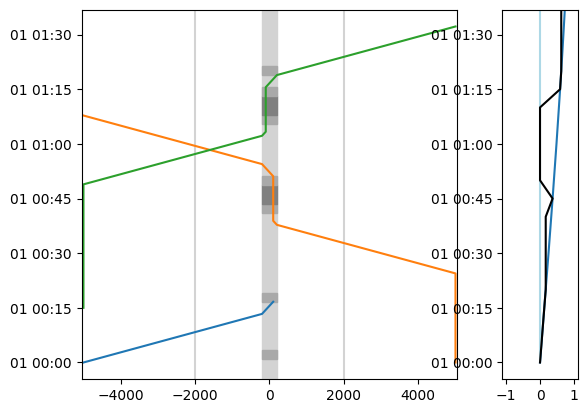

In [18]:
if len(lock.water_level):
    fig,axes = plt.subplots(1,2,width_ratios=[5,1])
    ax = axes[0]
else:
    fig,ax = plt.subplots()

for distances,times in zip(all_distances,all_times):
    ax.plot(distances,times)

ylimmin,ylimmax = ax.get_ylim()

#Plot lock chamber
x_lock_doorsA = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_A))-lock_edge_geometry.length/2
x_lock_doorsB = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_B))-lock_edge_geometry.length/2
lock_extend_x = [x_lock_doorsA,x_lock_doorsA,x_lock_doorsB,x_lock_doorsB]
ax.fill(lock_extend_x,[ylimmin,ylimmax,ylimmax,ylimmin],color='lightgrey',zorder=0)

#Plot lock phases
for index, message_info in lock_df.iterrows():
    if message_info.Message == 'Lock doors opening stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock doors closing stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock chamber converting stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='grey',zorder=0)

# for door_closed in door_A_closed:
#     ax.plot([lock_extend_x[0],lock_extend_x[0]],door_closed,color='k')

# for door_closed in door_B_closed:
#     ax.plot([lock_extend_x[-1],lock_extend_x[-1]],door_closed,color='k')

ax.axvline(-2000,color='lightgrey',zorder=0)
ax.axvline(2000,color='lightgrey',zorder=0)
ax.set_xlim(-5050,5050);
ax.set_ylim(ylimmin,ylimmax);

if len(lock.water_level):
    ax = axes[1]
    hydrodynamic_times = lock.env.vessel_traffic_service.hydrodynamic_times
    hydrodynamic_data = Dataset(lock.env.vessel_traffic_service.hydrodynamic_information_path)
    ax.plot(hydrodynamic_data['Water level'][0],hydrodynamic_times,'C0')
    ax.plot(hydrodynamic_data['Water level'][1],hydrodynamic_times,'lightblue')
    ax.plot(lock.water_level,hydrodynamic_times,'k')
    ax.set_ylim(ylimmin,ylimmax);

In [ ]:
test_results()

In [19]:
lock.operation_planning

,bound,vessels,capacity_L,capacity_B,time_potential_lock_door_opening_stop,time_operation_start,time_entry_start,time_entry_stop,time_door_closing_start,time_door_closing_stop,...,time_door_opening_stop,time_departure_start,time_departure_stop,time_operation_stop,time_potential_lock_door_closure_start,wlev_A,wlev_B,maximum_individual_delay,total_delay,status
lock_operation,,,,,,,,,,,,,,,,,,,,,
0,0,[<__main__.Vessel object at 0x0000026C2FE94AF0...,200,10,2025-01-01 00:03:20,2025-01-01 00:08:20,2025-01-01 00:13:20,2025-01-01 00:16:40,2025-01-01 00:16:40,2025-01-01 00:19:10,...,2025-01-01 00:26:40,2025-01-01 00:26:40,2025-01-01 00:27:46.666666666,2025-01-01 00:32:46.666666666,2025-01-01 00:28:46.666666666,0.166769,0.0,0 days 00:00:00,0 days 00:00:00,ready
1,1,[<__main__.Vessel object at 0x0000026C2FE96CE0>],200,10,2025-01-01 00:27:46.666666666,2025-01-01 00:32:46.666666666,2025-01-01 00:37:46.666666666,2025-01-01 00:41:06.666666666,2025-01-01 00:41:06.666666666,2025-01-01 00:43:36.666666666,...,2025-01-01 00:51:06.666666666,2025-01-01 00:51:06.666666666,2025-01-01 00:52:13.333333332,2025-01-01 00:57:13.333333332,2025-01-01 00:53:13.333333332,0.406737,0.0,0 days 00:24:26.666666666,0 days 00:24:26.666666666,ready
2,0,[<__main__.Vessel object at 0x0000026C2FE96710>],200,10,2025-01-01 00:52:13.333333332,2025-01-01 00:57:13.333333332,2025-01-01 01:02:13.333333332,2025-01-01 01:05:33.333333332,2025-01-01 01:05:33.333333332,2025-01-01 01:08:03.333333332,...,2025-01-01 01:15:33.333333332,2025-01-01 01:15:33.333333332,2025-01-01 01:16:39.999999998,2025-01-01 01:21:39.999999998,2025-01-01 01:17:39.999999998,0.553392,0.0,0 days 00:33:53.333333332,0 days 00:33:53.333333332,ready
